<a href="https://colab.research.google.com/github/fdavenport/CIVE480A6-climate-change-impacts/blob/main/lectures/04_Analyzing_Regional_Climate_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIVE 480A6: Climate Change Risks and Impacts
## Week 4: Analyzing Regional Temperature and Precipitation Data

Today's Objectives:
1. Learn more map-making features: adding points and labels, multiple maps in one figure, etc.
2. Learn how to define our own functions.
3. Look at data for individual grid cells.
4. Calculate and interpret trend lines.

## Part 1: More Advanced Map-making

Today we will be looking at a different raster dataset called "[PRISM](https://prism.oregonstate.edu/)". PRISM stands for "Parameter-elevation Regressions on Independent Slopes Model". This dataset combines observations from many different monitoring stations. In today's lecture, we will analyze annual mean temperature and annual precipitation data for Florida.

<img src="https://raw.githubusercontent.com/fdavenport/CIVE480A6-climate-change-impacts/main/lectures/img/PRISM_tmax_30yr_normal_4kmM2_05.png" width="700">

In [1]:
#The data has already been added to the course github page at the following link:
prism_FL_temp_url = "https://raw.githubusercontent.com/fdavenport/CIVE480A6-climate-change-impacts/main/lectures/data/PRISM_FL_annual_temp_1895_2023.nc"
prism_FL_precip_url = "https://raw.githubusercontent.com/fdavenport/CIVE480A6-climate-change-impacts/main/lectures/data/PRISM_FL_annual_precip_1895_2023.nc"

# This file is too large to read from github, so we will need to download it within colab
# using something called "wget"
!wget {prism_FL_temp_url} -O prism_FL_temp.nc
!wget {prism_FL_precip_url} -O prism_FL_precip.nc

--2024-09-12 18:38:02--  https://raw.githubusercontent.com/fdavenport/CIVE480A6-climate-change-impacts/main/lectures/data/PRISM_FL_annual_temp_1895_2023.nc
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29666810 (28M) [application/octet-stream]
Saving to: ‘prism_FL_temp.nc’

prism_FL_temp.nc    100%[===================>]  28.29M   126MB/s    in 0.2s    

2024-09-12 18:38:04 (126 MB/s) - ‘prism_FL_temp.nc’ saved [29666810/29666810]

--2024-09-12 18:38:04--  https://raw.githubusercontent.com/fdavenport/CIVE480A6-climate-change-impacts/main/lectures/data/PRISM_FL_annual_precip_1895_2023.nc
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.github

In [2]:
# we will use the same packages as last class
import xarray as xr
import matplotlib.pyplot as plt

!pip install cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs

In [3]:
## let's load the temperature data

temp_data = xr.open_dataset("prism_FL_temp.nc")

In [4]:
## view the data

temp_data

<xarray.Dataset> Size: 30MB
Dimensions:      (longitude: 183, latitude: 157, year: 129)
Coordinates:
  * longitude    (longitude) float64 1kB -87.62 -87.58 -87.54 ... -80.08 -80.04
  * latitude     (latitude) float64 1kB 31.0 30.96 30.92 ... 24.58 24.54 24.5
  * year         (year) int64 1kB 1895 1896 1897 1898 ... 2020 2021 2022 2023
Data variables:
    Temperature  (latitude, longitude, year) float64 30MB ...
Attributes:
    created_by:  Frances Davenport, from PRISM monthly data

In [5]:
## let's make a map of the data

# let's get the data for 2023:
x = temp_data["longitude"]
y = temp_data["latitude"]
z = temp_data.sel(year = 2023)["Temperature"]

Text(-84.0806, 30.338199999999997, 'Tallahassee')

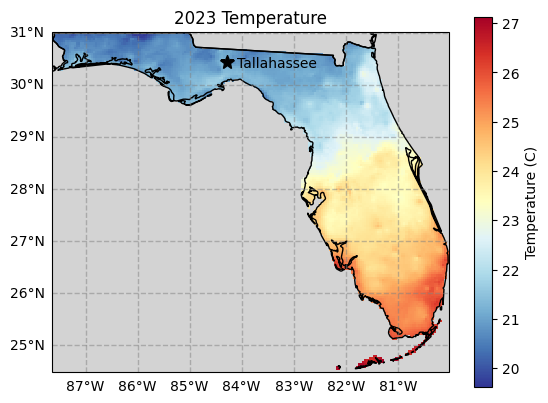

In [6]:
## make a map of the data

fig, ax = plt.subplots(subplot_kw = {"projection": ccrs.PlateCarree()})


temp = ax.pcolormesh(x, y, z, cmap = "RdYlBu_r")
plt.colorbar(temp, label = "Temperature (C)")
ax.set_title("2023 Temperature")

## add state border
ax.add_feature(cfeature.STATES.with_scale("10m"))

## add background color
ax.set_facecolor("lightgray")

## add latitude-longitude gridlines
gridlines = ax.gridlines(draw_labels = True, crs = ccrs.PlateCarree(), linewidth = 1,
                         color = "gray", alpha = 0.5, linestyle = "--")
gridlines.top_labels = False
gridlines.right_labels = False

## add tallahassee location
tallahassee_lat = 30.4382
tallahassee_lon = -84.2806

ax.plot(tallahassee_lon, tallahassee_lat, marker = "*", markersize = 10, color = "black")
ax.annotate("Tallahassee", (tallahassee_lon + 0.2, tallahassee_lat - 0.1))

Let's try making an interactive map so that we can scroll through different years!

In [7]:
## we need to import a new library called plotly
import plotly.graph_objects as go

In [8]:
## let's take a subset of the data to look at for our interactive map

plot_data = temp_data.sel(year = slice(1994, 2023))["Temperature"]

In [9]:
## make an interactive plot:

# Plotly heatmap with slider
# Initialize the figure
fig = go.Figure()

# Initial heatmap (first time slice)
heatmap = go.Heatmap(z=plot_data.isel(year=0).values, x=plot_data['longitude'].values, y=plot_data['latitude'].values,
                     colorscale='RdYlBu_r', zmin = 18, zmax = 28)
fig.add_trace(heatmap)

# Create frames for each time step
frames = [go.Frame(data=[go.Heatmap(z=plot_data.isel(year=i).values, x=plot_data['longitude'].values,
                                    y=plot_data['latitude'].values,
                                    colorscale='RdYlBu_r', zmin = 18, zmax = 28)],
                   name=str(i)) for i in range(plot_data.sizes['year'])]

fig.frames = frames

# Define slider steps
slider_steps = [
    dict(method="animate",
         args=[[str(i)], dict(frame=dict(duration=300, redraw=True), mode="immediate")],
         label=f"Year {plot_data['year'].values[i]:.1f}")
    for i in range(plot_data.sizes['year'])
]

fig.update_layout(
    updatemenus=[dict(type="buttons", showactive=False,
                      buttons=[dict(label="Play", method="animate",
                                    args=[None, dict(frame=dict(duration=300, redraw=True),
                                                     fromcurrent=True, mode='immediate')])])],
    sliders=[dict(steps=slider_steps)],
    width = 600,
    height = 600
)

fig.show()


Let's go back to analyzing our data one year at a time. We have two variables (temperature and precipitation), so it might be helpful to see two maps side by side.

In [10]:
## let's load the precip data
precip_data = xr.open_dataset("prism_FL_precip.nc")

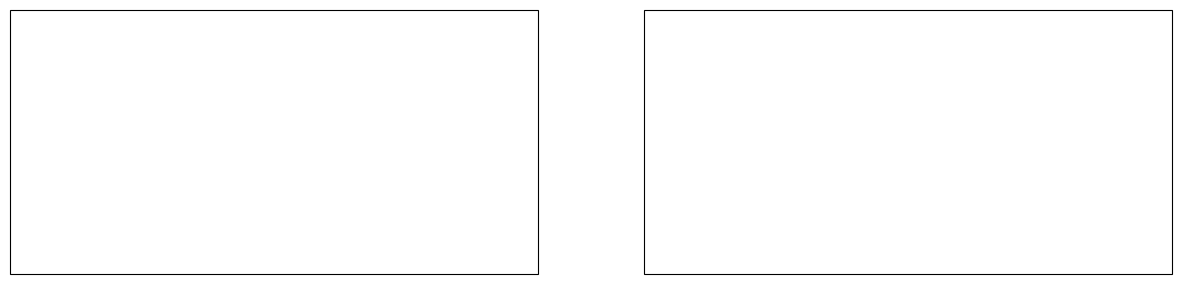

In [11]:
## create two axes side by side:

fig, axes = plt.subplots(nrows = 1, ncols = 2, subplot_kw = {"projection": ccrs.PlateCarree()}, figsize = (15, 6))


Text(-84.0806, 30.338199999999997, 'Tallahassee')

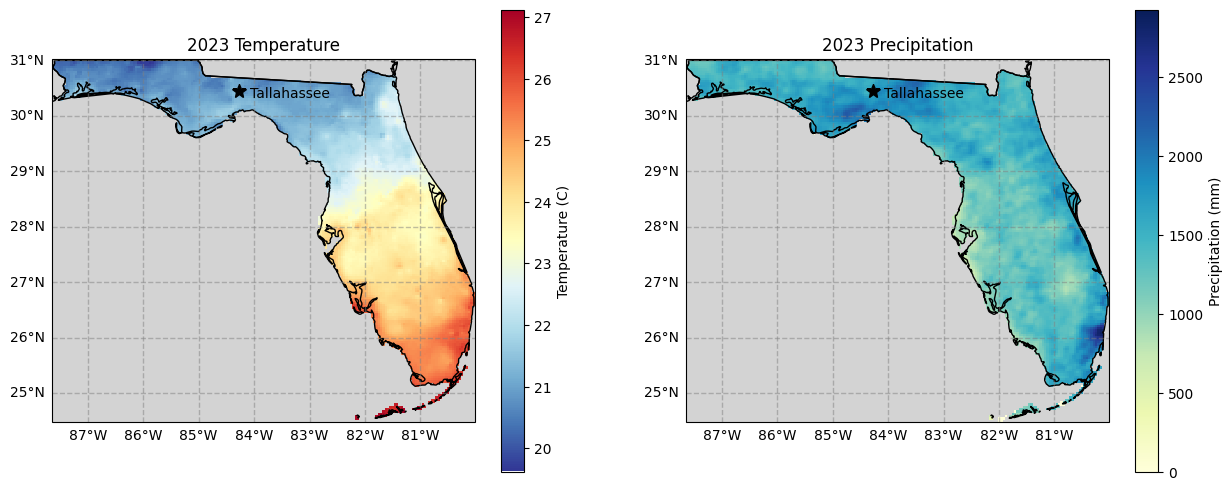

In [12]:
## two maps side by side, temperature on the left and precipitation on the right

fig, axes = plt.subplots(nrows = 1, ncols = 2, subplot_kw = {"projection": ccrs.PlateCarree()}, figsize = (15, 6))

## Temperature map on left
## the left axis is axes[0]
temp = axes[0].pcolormesh(x, y, z, cmap = "RdYlBu_r")
plt.colorbar(temp, label = "Temperature (C)")
axes[0].set_title("2023 Temperature")

axes[0].add_feature(cfeature.STATES.with_scale("10m"))
axes[0].set_facecolor("lightgray")

gridlines = axes[0].gridlines(draw_labels = True, crs = ccrs.PlateCarree(), linewidth = 1,
                         color = "gray", alpha = 0.5, linestyle = "--")
gridlines.top_labels = False
gridlines.right_labels = False

tallahassee_lat = 30.4382
tallahassee_lon = -84.2806

axes[0].plot(tallahassee_lon, tallahassee_lat, marker = "*", markersize = 10, color = "black")
axes[0].annotate("Tallahassee", (tallahassee_lon + 0.2, tallahassee_lat - 0.1))


## Precipitation map on right
## the right axis is axes[1]
x2 = precip_data["longitude"]
y2 = precip_data["latitude"]
z2 = precip_data.sel(year = 2023)["Precipitation"]

precip = axes[1].pcolormesh(x2, y2, z2, cmap = "YlGnBu")
plt.colorbar(precip, label = "Precipitation (mm)")
axes[1].set_title("2023 Precipitation")

axes[1].add_feature(cfeature.STATES.with_scale("10m"))
axes[1].set_facecolor("lightgray")

gridlines = axes[1].gridlines(draw_labels = True, crs = ccrs.PlateCarree(), linewidth = 1,
                         color = "gray", alpha = 0.5, linestyle = "--")
gridlines.top_labels = False
gridlines.right_labels = False

axes[1].plot(tallahassee_lon, tallahassee_lat, marker = "*", markersize = 10, color = "black")
axes[1].annotate("Tallahassee", (tallahassee_lon + 0.2, tallahassee_lat - 0.1))

You can adjust the formatting for your homework however you like, as long as you include labels and units for each map. Here is the page with more colormap options: https://matplotlib.org/stable/gallery/color/colormap_reference.html


If we are making a lot of maps, it's annoying to have to type the formatting code over and over again. Instead, we can define our own function that will apply the formatting every time we use the function.

In [13]:
## first let's define a more basic python function so that we can see how functions work
## we will create a function that takes one value as input, and adds two to that value, then returns the answer

def add_two(x):
  ## the commands in the function need to be indented by four spaces
  x_new = x+2
  return(x_new)

## let's test out the function

add_two(3)

5

Now, let's make a function that applies our map formatting. The function will only include formatting that we want to apply to every map. For now, we won't add things like a title or labels, because those will change from map to map.

In [14]:
## define function
def format_map(axis):

    axis.add_feature(cfeature.STATES.with_scale("10m"))
    axis.set_facecolor("lightgray")

    gridlines = axis.gridlines(draw_labels = True, crs = ccrs.PlateCarree(), linewidth = 1,
                         color = "gray", alpha = 0.5, linestyle = "--")
    gridlines.top_labels = False
    gridlines.right_labels = False

    axis.plot(tallahassee_lon, tallahassee_lat, marker = "*", markersize = 10, color = "black")
    axis.annotate("Tallahassee", (tallahassee_lon + 0.2, tallahassee_lat - 0.1))

    ## we are not returning any new values from this function, so we don't need to include a return statement like we did up above

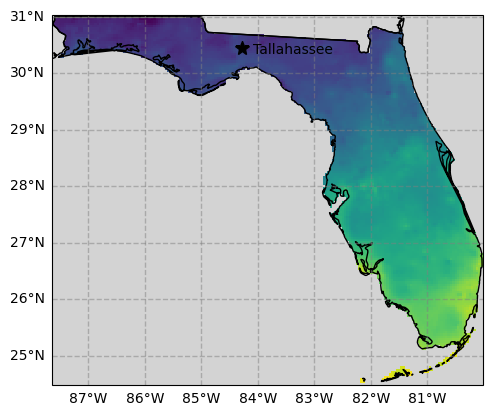

In [15]:
# Let's try applying this function to a basic map:

fig, ax = plt.subplots(subplot_kw = {"projection": ccrs.PlateCarree()})

ax.pcolormesh(x, y, z)
format_map(axis = ax)

Last class we looked at averaging temperature over many years, and then looking at how that averaged had changed over time. Let's apply that again here for practice. We will use the past 30 years (1994-2023) to calculate average temperature over the recent period and we will compare that to what average temperatures were like ~130 years ago (using the 30-year period from 1895-1924).

In [16]:
## How have temperature and precipitation changed over time?

temp_recent = temp_data.sel(year = slice(1994, 2023)).mean(dim = "year")
temp_early = temp_data.sel(year = slice(1894, 1924)).mean(dim = "year")
temp_change = temp_recent - temp_early

precip_recent = precip_data.sel(year = slice(1994, 2023)).mean(dim = "year")
precip_early = precip_data.sel(year = slice(1894, 1924)).mean(dim = "year")
precip_change = precip_recent - precip_early

In [17]:
temp_change

<xarray.Dataset> Size: 233kB
Dimensions:      (longitude: 183, latitude: 157)
Coordinates:
  * longitude    (longitude) float64 1kB -87.62 -87.58 -87.54 ... -80.08 -80.04
  * latitude     (latitude) float64 1kB 31.0 30.96 30.92 ... 24.58 24.54 24.5
Data variables:
    Temperature  (latitude, longitude) float64 230kB nan nan nan ... nan nan nan

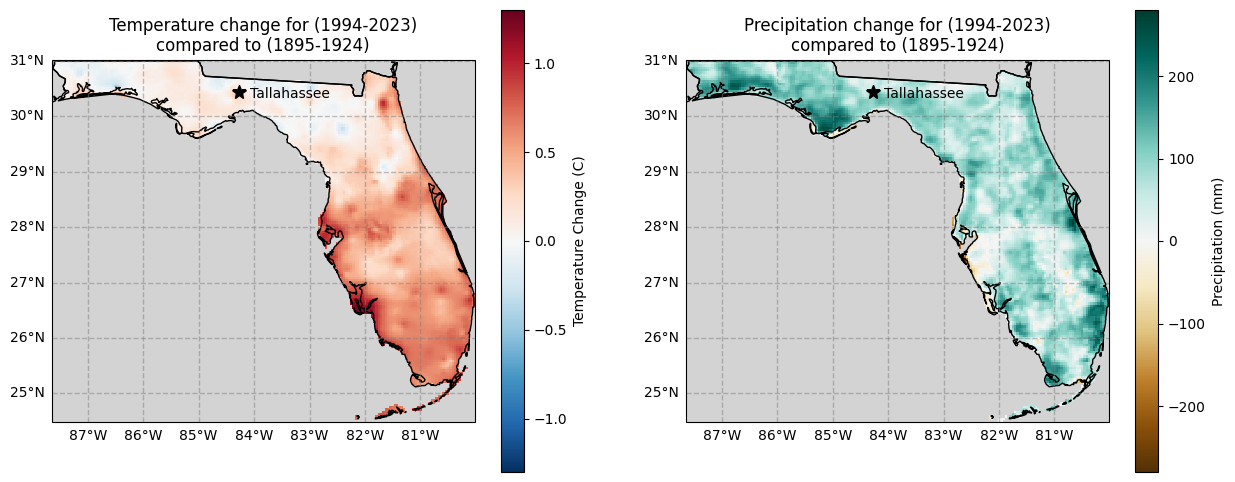

In [18]:
## now let's make maps of the change
fig, axes = plt.subplots(nrows = 1, ncols = 2, subplot_kw = {"projection": ccrs.PlateCarree()}, figsize = (15, 6))

## map of temperature change on left
temp = axes[0].pcolormesh(temp_change["longitude"], temp_change["latitude"], temp_change["Temperature"], cmap = "RdBu_r", vmin = -1.3, vmax = 1.3)
plt.colorbar(temp, label = "Temperature Change (C)")
axes[0].set_title("Temperature change for (1994-2023)\ncompared to (1895-1924)") ## adding \n creates a line break in the string

format_map(axes[0])


## map of precipitation change on the right

precip = axes[1].pcolormesh(precip_change["longitude"], precip_change["latitude"], precip_change["Precipitation"], vmin = -280, vmax = 280, cmap = "BrBG")
plt.colorbar(precip, label = "Precipitation (mm)")
axes[1].set_title("Precipitation change for (1994-2023)\ncompared to (1895-1924)")

format_map(axes[1])

For the precipitation map, I chose a colormap call "BrBG", which uses brown for places that have gotten drier, and green for places that have gotten wetter.

## Part 2: Looking at data for individual grid cells

Interestingly, it looks like some parts of the state have warmed about 1 degree celsius. Other parts in the north, like Tallahassee, seem like they haven't warmed at all. Let's look at what's going on in Tallahassee more closely.



In [19]:
## Let's look at the data for Tallahassee more closely...

# subset our original data based on latitude and longitude
tal_temp_data = temp_data.sel(latitude = tallahassee_lat, longitude = tallahassee_lon, method = "nearest")
tal_precip_data = precip_data.sel(latitude = tallahassee_lat, longitude = tallahassee_lon, method = "nearest")

In [20]:
# we see that now we still have 129 years of data, but only for one location

tal_temp_data

<xarray.Dataset> Size: 2kB
Dimensions:      (year: 129)
Coordinates:
    longitude    float64 8B -84.29
    latitude     float64 8B 30.46
  * year         (year) int64 1kB 1895 1896 1897 1898 ... 2020 2021 2022 2023
Data variables:
    Temperature  (year) float64 1kB ...
Attributes:
    created_by:  Frances Davenport, from PRISM monthly data

Let's create time series graphs of annual mean temperature and annual precipitation for Tallahassee:

[Text(0, 0.5, 'Precipitation (mm)'),
 Text(0.5, 0, 'year'),
 Text(0.5, 1.0, 'Tallahassee Annual Precipitation')]

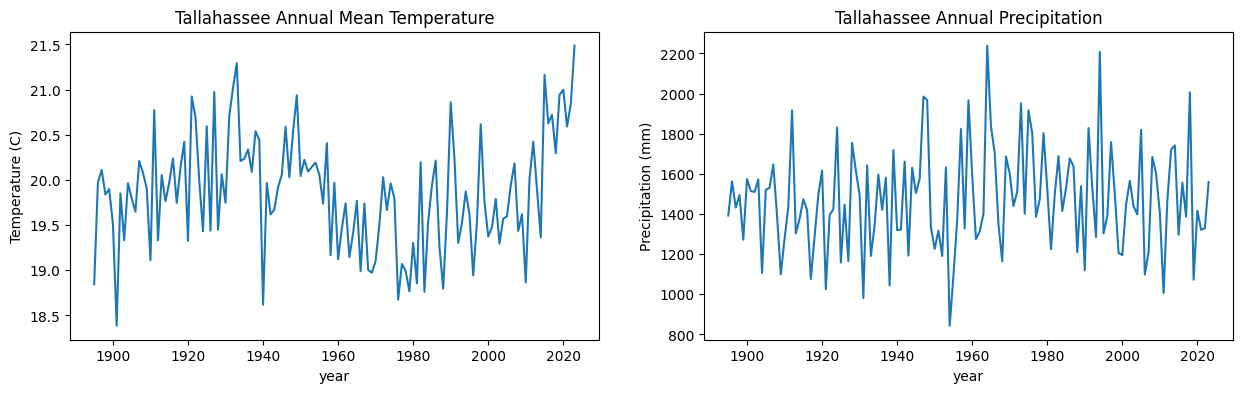

In [21]:
# make a time series graph of the Tallahasee temperature and precipitation data

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 4))


x = tal_temp_data["year"]
y = tal_temp_data["Temperature"]
axes[0].set(ylabel = "Temperature (C)", xlabel = "year", title = "Tallahassee Annual Temperature")

x2 = tal_precip_data["year"]
y2 = tal_precip_data["Precipitation"]


axes[0].plot(x, y)
axes[0].set(ylabel = "Temperature (C)", xlabel = "year", title = "Tallahassee Annual Mean Temperature")

axes[1].plot(x2, y2)
axes[1].set(ylabel = "Precipitation (mm)", xlabel = "year", title = "Tallahassee Annual Precipitation")

Hmmm...what does this tell us?
We see that temperature in Tallahassee has fluctuated a lot over time, with a relatively warmer period around 1920-1930 and a cool period between around 1960-1980. More recently, temperatures have started to increase pretty consistently over the past 20-30 years.

The precipitation time series also shows some fluctuations. It's a bit harder to tell if precipitation has increased or decreased.

## Part 3: Calculating trend lines in climate data

Now, we will learn how to calculate the rate of change over time using trend lines. This can help us understand more about how the temperature and precipitation patterns are changing.

First, a bit of background. You may also hear a trend line called "linear regression" or "line of best fit". These all mean the same thing. The trend line is the line that best fits the data. What does this mean mathematically? For each point, there is some vertical distance between the line and the point. We call this the residual. The line of best fit is the line that minimizes the sum of the residuals from all of the points.




Like any straight line, the equation for a trend line can be represented as $y = mx+b$.


* $m$ is also known as the slope of the line
* $b$ is the y-intercept (where the line crosses the y axis when x = 0)

<img src="https://raw.githubusercontent.com/fdavenport/CIVE480A6-climate-change-impacts/main/lectures/img/regression.png" width="800">

In [22]:
## to fit a trend line, we will need to import a new library called scipy

import scipy


In [23]:
## fit a trendline
scipy.stats.linregress(x = tal_temp_data["year"], y = tal_temp_data["Temperature"])

LinregressResult(slope=0.00019826798277595322, intercept=19.476844417015872, rvalue=0.011871643196439042, pvalue=0.8937756362142368, stderr=0.0014818672027174327, intercept_stderr=2.9035022682623084)

This gives us the result of our trendline. There are a couple different things here to look at.

First we see the slope and the intercept values. These tell us the coefficients for our line, m and b.

The slope is in units of degrees C per year.

The intercept is in units of degrees C.

Next, we see something called "rvalue". The r-value is the correlation. This tells us about whether there is a positive relationship or a negative relationship between x and y. It also tells us how scattered the points are. If the points are all really close to the line, the absolute value of the correlation is higher. If the points are more scattered and farther from the line, the absolute value of r is lower. This figure shows correlation values for different example data:

<img src="https://raw.githubusercontent.com/fdavenport/CIVE480A6-climate-change-impacts/main/lectures/img/correlation.png" width="800">

You don't need to pay too much attention to the correlation now - we will come back to it later in the semester.


The next thing we see is the "pvalue". The p-value tells us the statistical significance of the trend. To understand p-values, it helps to have a refresher on hypothesis testing. For the case of trend analysis, our null hypothesis ($H_0$) is that there is no relationship between x and y. In otherwords, $m=0$. Our alternative hypothesis ($H_1$) is that $ m \neq 0$. You may see this written as:

$H_0: m = 0$

$H_1: m \neq 0$

We can't prove that $H_1$ is true. However, we can determine whether or not $H_0$ is very likely based on our data. If we find that $H_0$ is very unlikely, we can reject the null hypothesis and say that $H_1$ is more likely.

The p-value tells us the probability that $H_0$ is true. So, a p-value of 0.02 means there is only a 2% chance that $H_0$ is correct and there is no true relationship between x and y. If the p-value is very low, say below 0.1 or 0.05, we would say that the null hypothesis is unlikely and $H_1$ is more likely. If the p-value is greater than about 0.1, we would say that the null hypothesis could be true, and we can't say for sure whether there is a relationship between x and y.

Generally, a higher slope will correspond to a higher p-value, but this is not always the case. It also depends on how spread out the points are around the line. For this class, we won't spend too much time talking about p-values, but it can help you understand how likely it is that there is a true trend in the data.



In [24]:
## let's rerun our trend again, but save the result as a variable so we can refer back to it

trend = scipy.stats.linregress(x = tal_temp_data["year"], y = tal_temp_data["Temperature"])

In [25]:
## we can print the different information about the trend like this:

trend.slope

0.00019826798277595322

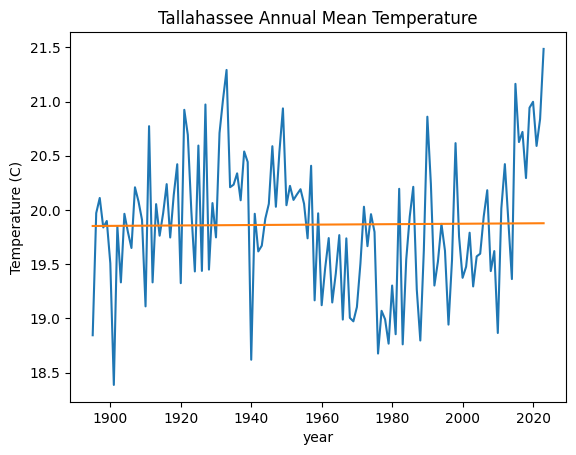

In [26]:
# Now, let's add the trendline to our temperature graph

fig, ax = plt.subplots()

ax.plot(x, y)
ax.set(ylabel = "Temperature (C)", xlabel = "year", title = "Tallahassee Annual Mean Temperature")

## we use the equation of a line to calculate the y values for our trend:
y_trend = x*trend.slope + trend.intercept

ax.plot(x, y_trend)

This shows us that there isn't a very strong trend (the slope is only about 0.0002 deg C per year) over the entire period. But, we can also calculate trends for different time periods.

In [27]:
trend_1895 = scipy.stats.linregress(x = tal_temp_data["year"], y = tal_temp_data["Temperature"])

# slice the data to only get the years since 1970
trend_1970 = scipy.stats.linregress(x = tal_temp_data.sel(year = slice(1970, 2023))["year"], y = tal_temp_data.sel(year = slice(1970, 2023))["Temperature"])

# slice the data to only get the years since 2000
trend_2000 = scipy.stats.linregress(x = tal_temp_data.sel(year = slice(2000, 2023))["year"], y = tal_temp_data.sel(year = slice(2000, 2023))["Temperature"])

trend_2015 = scipy.stats.linregress(x = tal_temp_data.sel(year = slice(2015, 2023))["year"], y = tal_temp_data.sel(year = slice(2015, 2023))["Temperature"])

Let's add these trend lines to our temperature graph:

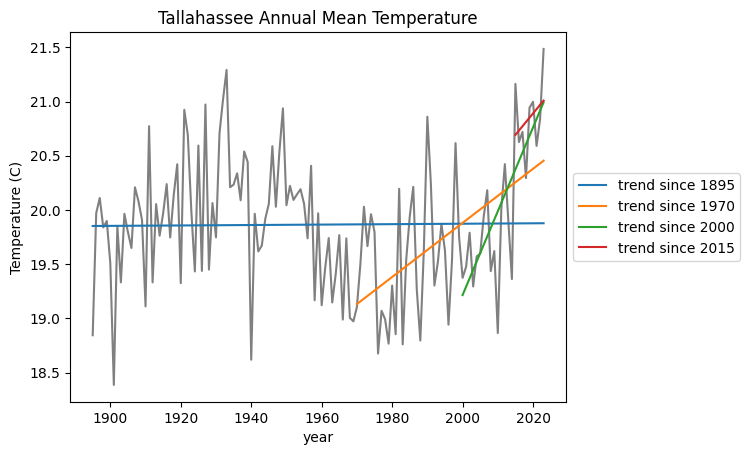

In [28]:
fig, ax = plt.subplots()

ax.plot(x, y, color = "gray")
ax.set(ylabel = "Temperature (C)", xlabel = "year", title = "Tallahassee Annual Mean Temperature")

## add the trend lines
ax.plot(x, x*trend_1895.slope + trend_1895.intercept, label = "trend since 1895")
x_1970 = tal_temp_data.sel(year = slice(1970, 2023))["year"]
x_2000 = tal_temp_data.sel(year = slice(2000, 2023))["year"]
x_2015 = tal_temp_data.sel(year = slice(2015, 2023))["year"]
ax.plot(x_1970, x_1970*trend_1970.slope + trend_1970.intercept, label = "trend since 1970")
ax.plot(x_2000, x_2000*trend_2000.slope + trend_2000.intercept, label = "trend since 2000")
ax.plot(x_2015, x_2015*trend_2015.slope + trend_2015.intercept, label = "trend since 2015")

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Now, it's a bit more clear that temperature have been increasing over the past 50 years, and increasing at an even faster rate over the past 20 years. Over the past 9 years, the slope flattens out some. We can also see this by printing out the slopes:

In [29]:
print("The trend slope since 1970 is ", str(trend_1970.slope), "deg C per year")
print("The trend slope since 2000 is ", str(trend_2000.slope), "deg C per year")
print("The trend slope since 2015 is ", str(trend_2015.slope), "deg C per year")

The trend slope since 1970 is  0.024952727561795316 deg C per year
The trend slope since 2000 is  0.07730843102601614 deg C per year
The trend slope since 2015 is  0.03950498626049945 deg C per year


We can also look at the p-values:

In [30]:
print("The p-value of the trend since 1970 is ", str(trend_1970.pvalue))
print("The p-value of the trend since 2000 is ", str(trend_2000.pvalue))
print("The p-value of the trend since 2015 is ", str(trend_2015.pvalue))

The p-value of the trend since 1970 is  5.339474785425664e-06
The p-value of the trend since 2000 is  5.675113342599889e-06
The p-value of the trend since 2015 is  0.4171183768031044


For the trends since 1970 and 1980, we see that the p-values are very small, on the order of $10^{-6}$. This tells us that there is definitely a relationship between time and temperature over the past 50 years (in other words, the temperature has changed over time).

If we want to understand how temperatures are changing in Tallahassee more recently, it might be helpful to look at these more recent trends. But, if the trend is too short, it might not give us enough information.

For the trend since 2015, we see that the p-value is about 0.4. The reality is that 9 years usually isn't long enough to detect whether there is a true trend because of how variable temperatures are from year to year. We've also talked about many different factors like volcanoes and ocean patterns that can influence the climate for a couple years at a time. If you only analyze a trend over a 10-year period, there's a higher likelihood that some of these factors will affect the pattern.


### Final Note
You might be wondering why Tallahassee had such unusual climate variations between 1900 and 2000. It turns out that much of the southeast U.S. actually experienced cooling over the 20th  century. In addition to global warming, there are multiple factors that likely contributed to temperature patterns in the region over the 20th and 21st centuries, including:
* [reforestation cooling the land surface](https://www.theguardian.com/environment/2024/feb/17/us-east-trees-warming-hole-study-climate-crisis)
* [more cold weather outbreaks in the south because of a wavier jet stream](https://www.forbes.com/sites/trevornace/2018/02/20/defying-climate-change-southeast-u-s-is-getting-colder-instead-of-warmer-via-polar-vortex/)
* [more summertime precipitation leading to cooler summer](https://cpo.noaa.gov/why-has-the-summertime-central-u-s-warming-hole-not-disappeared/)

You don't need to know this for class, but you're welcome to read more about this if you're interested.

